# Using high-pass filter differences to gain insight on forest service road sediment transport

**Lauren Wittkopf**  

**CEE 467, Geospatial Data Analysis, Winter 2023**




## Introduction

Erosion of gravel forest roads can have significant impacts on hydrology and sediment transport processes in forested ecosystems. Understanding the erosion processes occurring on forest roads is critical to mitigating sediment production in an effective and efficient way. This project is a part of Amanda Alvis' Ph.D. research investigating the sediment transport dynamics of mainline logging roads in western Washington and contributes by using high-resolution digital surface models (DSMs) to help parameterize a larger sediment transport model.

## Objectives

The objectives of Amanda's research are to identify areas of high sediment accumulation and erosion and to characterize the extent and rate of wheel rut development, with the overall goal being to investigate the impact of traffic and maintenance practices on forest road erosion.

The objectives of my project are to develop a data analysis product that takes an input of a GeoTiff DSM in an arbitrary coordinate system and produces figures that aid in sediment transport analysis 

## Methods

I have used the following methods to achieve our objectives:

### DSM Creation

I used Pix4D to create high-resolution DSMs of the study area that are in an arbitrary coordinate system. This allows me to export a GeoTiff after 3 steps of processing. This process was repeated for multiple flight dates to generate a time series of DSMs.

### Loading data and adding overviews

I added Gaussian overviews to these DEMs using `gdaladdo` and then opened them using rioxarray to produce xArray DataSets. I opened overview 2 to use for testing, and the full resolution to use in presentation. 

### Clipping, Reprojecting and Matching

These DataArrays could then be clipped to a QGIS-drawn polygon using `xda.rio.clip(mask_gdf.geometry)` where xda is the xArray DataArray and mask_gdf is the shapefile loaded using `gpd.read_file()`. One of these clipped DataSets also then had to be reprojected to match the other one, so that they can be differenced. I did so using `xda1_proj = rioxarray.rio.reproject_match(xda2)` I also extracted the extent for plotting all the data from the xArray DataSet using the [rio accessor base class](https://corteva.github.io/rioxarray/html/rioxarray.html) `xds.rio.bounds()`.

### Differencing

After two datasets have been loaded and reprojected to match abitrary coordinate systems, they can be differenced and plotted. Amanda did this with rasterio-powered masked 2D arrays, but using rioxarray-powered DataArrays allowed me to reproject and match without using gdalwarp, to load overviews that make processing time faster, and to keep the data in an arbitrary engineering CRS that can be located in an EPSG CRS later. Similar to the plots Amanda produced with rasterio however, these difference figures show long-wave deposition and erosion across the entire road (wave is oriented longitudinally), which is likely an artifact from the drone surveys and processing of the images to make the DSMs. This is when the high-pass filter comes in.

### High-pass Gaussian filtering

The analysis needs to be done on the change in the micro-topographical features on the road over time, so differencing that mostly shows the long wave noise from processing is not ideal. The high-pass filter allows me to perform another kind of difference on the simple difference I made before. This time I apply a high-pass filter (there are elements of Gaussian sampling and Fourier fast transform helping with the pygeotools function that can do this...I am not sure of the details) to the initial difference map, which produces a smoothed version of the difference map, with statistically-sound methods of smoothing the roads features. I can change the sigma cut-off value to change the size of features that it is smoothing. For the second overviews of these DEMs I chose to use a sigma value of 10, which correlates to kernel smoothing size of 61 pixels, chosen by guidance from David and because by visual inspection and comparision I can see that the smoothed version does not have visible ruts, and so it will enable us to see the true rut formation in the next step in high-detail. For the full-resolution of these DEMs a sigma value of 50 works better. The next step is to take the difference of the initial difference and the smoothed version. This results in a DataArray that can be plotted to clearly demonstrate only the micro-topographical changes in the road between the two time periods, without the long-wave noise artifact from processing.   

## Next Steps

 - Figure out how to calculate the best sigma/size for gaussian kernel based on source resolution metadata so that user doesn't have to fiddle with it--This proved difficult to do, couldn't find a relevant parameter to base a calculation on/the parameters I tried did not allow me to properly calculate the best sigma
 - Figure out how to add interactive plot to zoom in on pieces of the road--changed code to automatically find pieces of road easier depending on extent of data...interactive is clunkier and takes up too much space for my taste
 - Code vmin+maxes and x+ylims to read info from data arrays and set themselves accordingly--Success on vmin/max! x/y lim trickier
 - Work with Amanda to develop a robust way to repeat these analyses meaningfully on many pairs of DEMs--Tested on other DEMs, works easily and well! Need more work to develop easy/robust way to produce usable analysis

## Conclusions


The main conclusion is that using the pygeotools fourier fast transform gaussian high-pass filter on these structure from motion surveys allows me to difference them without the influence of long-wave artifacts on the true deposition and erosion patterns. I also learned that doing the analysis on DataArray produced using rioxarray is an easier and more efficient way to handle these DEMs than opening them as 2D raster arrays using rasterio. Using the rioxarray objects allows me to difference them without orienting them in a geolocated CRS, although I did find it useful to use the GCP-guided coordinates to plot according to an accurately sized extent (made meters into meters, rather than being oriented in pixels). 

## Packages + support code needed:

These include many of the familiar packages, and an excerpt from the pygeotools package, imported as individual functions thanks to David and Shashank. I am running this notebook on Windows, and because of some apparant problems with system paths to gdal in rasterio on Windows I also ran `from osgeo import gdal` as a work-around thanks to much advice and troubleshooting with Amanda.  

In [172]:
# Import packages
from osgeo import gdal 
import numpy as np
import rasterio as rio
from rasterio import plot, mask
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import xarray as xr
import rioxarray as rioxarray
import geopandas as gpd
import astropy as ap

In [275]:
#Compiled from pygeotools (dshean) and himat2cryo repositories
#given to me by Shashank

def checkma(a, fix=False):
    #isinstance(a, np.ma.MaskedArray)
    if np.ma.is_masked(a):
        out=a
    else:
        out=np.ma.array(a)
    #added to original code:
    return out

def maskfill(a, iterations=1, erode=False):
    import scipy.ndimage as ndimage 
    a = checkma(a)
    if erode:
        a = mask_islands(a, iterations)
    bmask = (~np.ma.getmaskarray(a))
    bmask_filled = ndimage.morphology.binary_fill_holes(bmask)
    #This will create valid values with a.filled in the original ma
    #a_erode.mask[:] = ~bmask_filled
    #return a_erode
    return ~bmask_filled

def gauss_fltr_astropy_fft(dem, size=None, sigma=None, origmask=False, fill_interior=False):
    
    """
    ***From pygeotools, commit to mainstream repo after full testing***
    # I use this over the direct Gaussian astropy filter  as it is way faster for large kernels
    Astropy gaussian filter properly handles convolution with NaN
    http://stackoverflow.com/questions/23832852/by-which-measures-should-i-set-the-size-of-my-gaussian-filter-in-matlab
    width1 = 3; sigma1 = (width1-1) / 6;
    Specify width for smallest feature of interest and determine sigma appropriately
    sigma is width of 1 std in pixels (not multiplier)
    scipy and astropy both use cutoff of 4*sigma on either side of kernel - 99.994%
    3*sigma on either side of kernel - 99.7%
    If sigma is specified, filter width will be a multiple of 8 times sigma 
    Alternatively, specify filter size, then compute sigma: sigma = (size - 1) / 8.
    If size is < the required width for 6-8 sigma, need to use different mode to create kernel
    mode 'oversample' and 'center' are essentially identical for sigma 1, but very different for sigma 0.3
    The sigma/size calculations below should work for non-integer sigma
    """

    #import astropy.nddata
    import astropy.convolution
    dem = checkma(dem)
    #Generate 2D gaussian kernel for input sigma and size
    #Default size is 8*sigma in x and y directions
    #kernel = astropy.nddata.make_kernel([size, size], sigma, 'gaussian')
    #Size must be odd
    if size is not None:
        size = int(np.floor(size/2)*2 + 1)
        size = max(size, 3)
    #Truncate the filter at this many standard deviations. Default is 4.0
    truncate = 3.0
    if size is not None and sigma is None:
        sigma = (size - 1) / (2*truncate)
    elif size is None and sigma is not None:
        #Round up to nearest odd int
        size = int(np.ceil((sigma * (2*truncate) + 1)/2)*2 - 1)
    elif size is None and sigma is None:
        #Use default parameters
        sigma = 1
        size = int(np.ceil((sigma * (2*truncate) + 1)/2)*2 - 1)
    size = max(size, 3)
    kernel = astropy.convolution.Gaussian2DKernel(sigma, x_size=size, y_size=size, mode='oversample')

    print("Applying gaussian smoothing filter with size %i and sigma %0.3f (sum %0.3f)" % \
            (size, sigma, kernel.array.sum()))

    #This will fill holes
    #np.nan is float
    #dem_filt_gauss = astropy.nddata.convolve(dem.astype(float).filled(np.nan), kernel, boundary='fill', fill_value=np.nan)
    #dem_filt_gauss = astropy.convolution.convolve(dem.astype(float).filled(np.nan), kernel, boundary='fill', fill_value=np.nan)
    #Added normalization to ensure filtered values are not brightened/darkened if kernelsum != 1
    dem_filt_gauss = astropy.convolution.convolve_fft(dem.astype(float).filled(np.nan), kernel, boundary='fill', 
                                                      fill_value=np.nan, normalize_kernel=True,
                                                     allow_huge=True)
    #This will preserve original ndv pixels, applying original mask after filtering
    if origmask:
        print("Applying original mask")
        #Allow filling of interior holes, but use original outer edge
        if fill_interior:
            mask = maskfill(dem)
        else:
            mask = dem.mask
        dem_filt_gauss = np.ma.array(dem_filt_gauss, mask=mask, fill_value=dem.fill_value)
    out = np.ma.fix_invalid(dem_filt_gauss, copy=False, fill_value=dem.fill_value)
    out.set_fill_value(dem.fill_value.astype(dem.dtype))
    return out.astype(dem.dtype), size

In [276]:
#Define diverging color-ramp used in entire notebook
#color = 'PiYG'#Pink and Green
#color = 'RdBu'#Red and Blue
color = 'RdYlGn' #Red and Green with yellow in middle

## Methods with code

### Loading data and adding overviews


In [16]:
#These files are used as an example and the notebook can be run with any dsm.tif file substituted here
#In the plots vmins, vmaxs and x+y lims are all explicitly specified for my data, so those currently need to be changed accordingly
#The DSM marked by 2 should be collected after that marked by 1
fn_2 = '../MEL14_data/20220428_wittkopf5_MEL14_dsm.tif'
fn_1 = '../MEL14_data/20220309_wittkopf3_MEL14_dsm.tif'

Adding overviews using `gdaladdo` only needs to be done to a .tif once and some have them in their metadata already, so check whether overviews already exist and then uncomment code as needed. I've commented these out because they take a second to run, take up space in the notebook and I don't need them. 

In [6]:
#!gdalinfo $fn_2

In [7]:
#!gdaladdo $fn_2

In [8]:
#!gdalinfo $fn_1

In [9]:
#!gdaladdo $fn_1

Next step is to use `rioxarray.open_rasterio().squeeze` with `overview_level = 2` and `mask_and_scale = True` specified. Overview 2 was chosen because it is the lowest resolution that doesn't have visible blocks of pixels for these data. During testing of this code this was convenient to run the functions faster. I also load a DataArray of the full resolution version here, which I will use for the remainder of this example 

In [17]:
da_ov2_2 = rioxarray.open_rasterio(fn_2, overview_level = 2, mask_and_scale = True).squeeze()
da_ov2_1 = rioxarray.open_rasterio(fn_1, overview_level = 2, mask_and_scale = True).squeeze()

da_full_2 = rioxarray.open_rasterio(fn_2, mask_and_scale = True).squeeze()
da_full_1 = rioxarray.open_rasterio(fn_1, mask_and_scale = True).squeeze()

I'm also loading here a polygon shapefile drawn in QGIS according to the shape of the road. 

In [11]:
mask_path = '../MEL14_data/clip_shape.shp'
mask_gdf = gpd.read_file(mask_path)

### Clipping, Reprojecting and Matching

These DataArrays can then be clipped to a QGIS-drawn polygon using `xda.rio.clip(mask_gdf.geometry)` where xda is the xArray DataArray and mask_gdf is the shapefile I loaded using `gpd.read_file()`. One of these clipped DataArrays then has to be reprojected to match the other one, so that they can be differenced. I do so using `xda1_proj = rioxarray.rio.reproject_match(xda2)` I also extract the extent for plotting all the data from the xArray DataSet using the [rio accessor base class](https://corteva.github.io/rioxarray/html/rioxarray.html) `xds.rio.bounds()`.

In [274]:
#clipping using rioxarray
#be sure to specify desired resolution when calling the dataArray
da1_clipped = da_full_1.rio.clip(mask_gdf.geometry)
da2_clipped = da_full_2.rio.clip(mask_gdf.geometry)

#reprojecting and matching
da2_clipped_proj = da2_clipped.rio.reproject_match(da1_clipped, resampling = 3)
da_extent = da2_clipped_proj.rio.bounds()

### Differencing

After two datasets have been loaded and reprojected to match abitrary coordinate systems, they can be differenced and plotted.

In [283]:
#necessary for difference-based color-ramp limits below
#I chose this method to choose vmax and min based on a guess. There may be a more statistically sound way to do this or a better way to choose the 
#the multiplier than arbitrarily choosing 2, but I don't know that way. 
values = pd.DataFrame(diff.values).mean(1)
vmax = 2*values.max()
vmin = 2*values.min()

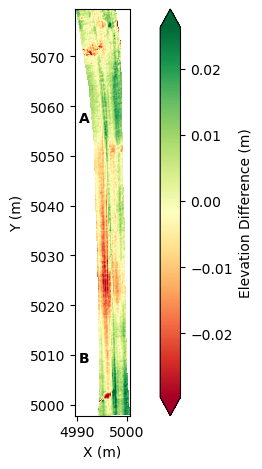

In [203]:
#difference and plotting
diff = da2_clipped_proj-da1_clipped

f, ax = plt.subplots()
plt.imshow(diff, cmap = color, vmin= vmin, vmax=vmax, extent = da_extent)
plt.colorbar(label='Elevation Difference (m)', extend='both')

b_spot = [0.175,0.16]
a_spot = [0.175, 0.75]

ax.text(b_spot[0],b_spot[1], 'B',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)
ax.text(a_spot[0],a_spot[1], 'A',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')

plt.tight_layout()
#plt.savefig('Difference_MEL_overview=2.png', bbox_inches='tight', dpi=300)
plt.show()

And we can zoom into A and B:

In [287]:
#necessary for extent-based plotting limits below
da_extent_y = da_extent[3]-da_extent[1]
a_top = da_extent[1]+0.5*a_spot[1]*da_extent_y
a_bottom = da_extent[1]+a_spot[1]*da_extent_y

b_bottom = da_extent[1]-0.3*b_spot[1]*da_extent_y
b_top = da_extent[1]+b_spot[1]*da_extent_y

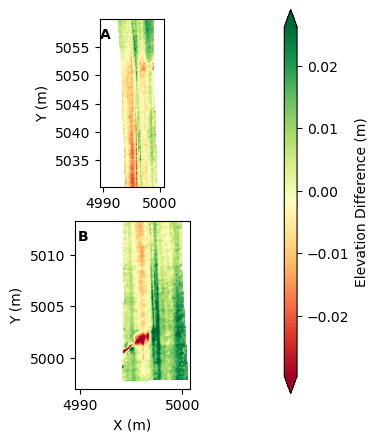

In [289]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1)

im = ax1.imshow(diff, cmap = color, vmin= vmin, vmax=vmax, extent = da_extent)
#as defined above
ax1.set_ylim(a_top, a_bottom)
ax1.set_ylabel('Y (m)')

ax2.imshow(diff, cmap = color, vmin= vmin, vmax=vmax, extent = da_extent)

ax2.set_ylim(b_bottom,b_top)

ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')


cb_ax = fig.add_axes([0.75, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax, label='Elevation Difference (m)', extend='both')

ax1.text(0.07, 0.95, 'A',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax1.transAxes)
ax2.text(0.07, 0.95, 'B',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax2.transAxes)

#fig.colorbar(ax=ax1,label='Elevation Difference (m)', extend='both')
#plt.tight_layout()
#plt.savefig('Difference_zoom.png', bbox_inches='tight', dpi=300)
plt.show()

While the micro-topographic features are clear in these zoomed windows, a longitudinal plot shows the wave that is visible in full road plot and has been identified as a noise artifact from processing. There also seem to be some spots where bad elevation values may be giving differences that are extreme and also post-processing noise. 

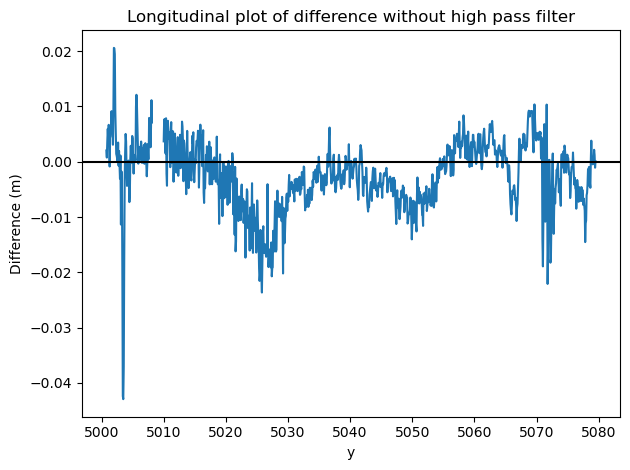

In [103]:
x = 4993

f, axa = plt.subplots()
diff.sel(x=x, method='nearest').plot(ax=axa)
axa.axhline(0, color='k')
axa.set_ylabel('Difference (m)')
axa.set_title('Longitudinal plot of difference without high pass filter')
#plt.savefig('longitudinal plot, x=4995, ov = 2.png', bbox_inches='tight', dpi=300)
plt.tight_layout()

### Longitudinal plot along road
Below is a plot of longitudinal profiles taken across the x-axis of the road, with a step of 0.5 meters. Only those longitudinal profiles that have valid data during most of the length of the road are included here. From this plot we can see that across the road there is a wave occuring that we need to flatten to see more signal and less noise. 

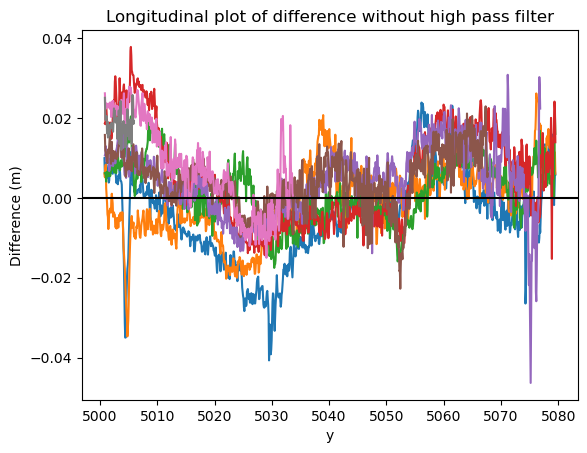

In [277]:
x = np.arange(4994, 4998.5, 0.5)

f, axa = plt.subplots()
ims = []
for i in x:
    ims.append(diff.sel(x=i, method='nearest').plot(ax=axa))
axa.axhline(0, color='k')
axa.set_ylabel('Difference (m)')
axa.set_title('Longitudinal plot of difference without high pass filter')
#attempt to animate but this is all it will show me
# anim = animation.ArtistAnimation(f, ims, interval=2000, repeat_delay=1000)
plt.show()

### High-pass Gaussian filtering

This is where the high-pass filter shines, allowing me to take another difference that eliminates the noise seen in the other difference. 

In [278]:
#This controls width of gaussian kernel standard deviation in pixels
#50 chosen for full resolution
#10 for overview 2
sigma = 10

diff_ma_smooth, size = gauss_fltr_astropy_fft(diff, sigma = sigma)

Applying gaussian smoothing filter with size 61 and sigma 10.000 (sum 0.995)


In [279]:
#resetting vmin and max for new difference values
values = pd.DataFrame(diff_hp.values).mean(1)
vmax_hp = 2*values.max()
vmin_hp = 2*values.min()

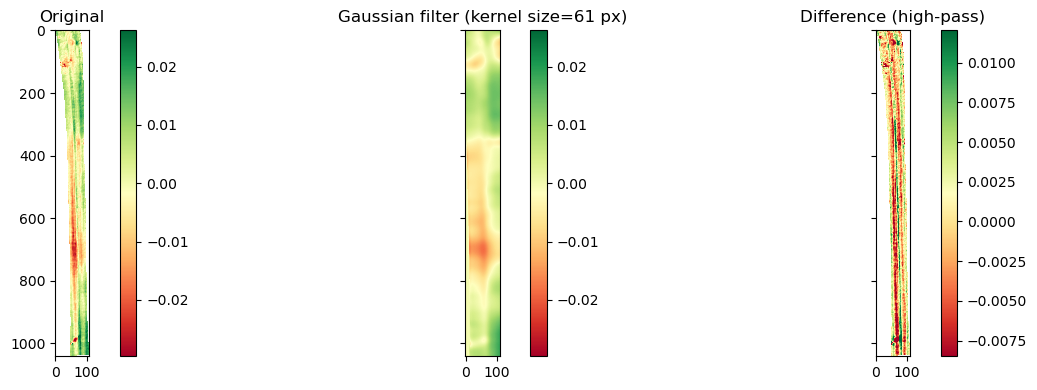

In [280]:
f, axa = plt.subplots(1,3, sharex=True, sharey=True, figsize=(15,4))
m = axa[0].imshow(diff, cmap = color , vmin = vmin, vmax = vmax)
f.colorbar(m, ax=axa[0])
axa[0].set_title("Original")
m = axa[1].imshow(diff_ma_smooth, cmap = color, vmin = vmin, vmax = vmax)
f.colorbar(m, ax=axa[1])
axa[1].set_title("Gaussian filter (kernel size=%s px)" % size)
diff_hp = diff - diff_ma_smooth
m = axa[2].imshow(diff_hp , cmap=color, vmin=vmin_hp, vmax=vmax_hp)
f.colorbar(m, ax=axa[2])
axa[2].set_title("Difference (high-pass)")
#plt.savefig('high-pass filter attempt 2, on diff.png', bbox_inches='tight', dpi=300)
plt.tight_layout()

Now we can look at the same longitudinal plot on the difference after the high pass filter and see that the long wave-form has been flattened so that the differences are more uniformly distributed about 0. So much better!

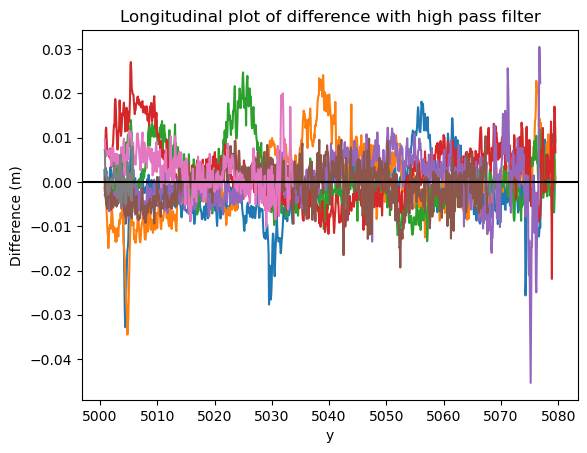

In [281]:
x = np.arange(4994, 4998.5, 0.5)

f, axa = plt.subplots()
ims = []
for i in x:
    ims.append(diff_hp.sel(x=i, method='nearest').plot(ax=axa))
axa.axhline(0, color='k')
axa.set_ylabel('Difference (m)')
axa.set_title('Longitudinal plot of difference with high pass filter')
#attempt to animate but this is all it will show me
# anim = animation.ArtistAnimation(f, ims, interval=2000, repeat_delay=1000)
plt.show()

We can also zoom in on those same areas and see a more meaningful result in micro-topographic feature resolution, with evenly formed ruts that aren't impacted by the road-long waveform

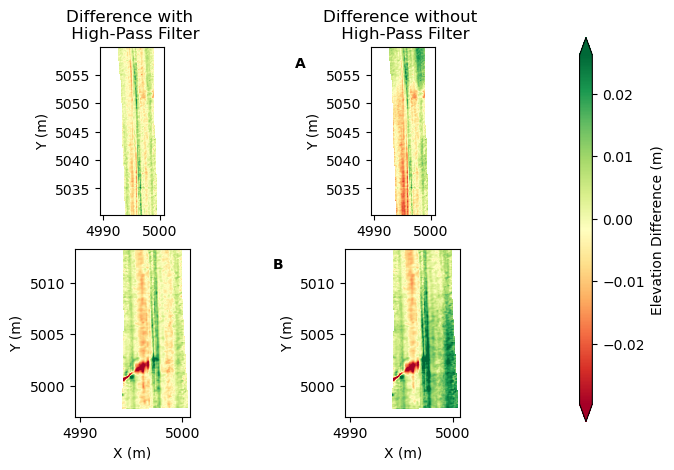

In [291]:
fig, axa = plt.subplots(nrows=2, ncols=2)

im1 = axa[0,0].imshow(diff_hp, cmap = color, vmin= vmin, vmax=vmax, extent = da_extent)
#axa[0,0].set_xlim(175,800)
axa[0,0].set_ylim(a_top, a_bottom)
axa[0,0].set_ylabel('Y (m)')
axa[0,0].set_title('Difference with \n High-Pass Filter')

im2 = axa[1,0].imshow(diff_hp, cmap = color, vmin= vmin, vmax=vmax, extent = da_extent)
#axa[1,0].set_xlim(320,850)
axa[1,0].set_ylim(b_bottom,b_top)
axa[1,0].set_xlabel('X (m)')
axa[1,0].set_ylabel('Y (m)')

im3 = axa[0,1].imshow(diff, cmap = color, vmin= vmin, vmax=vmax, extent = da_extent)
#axa[0,1].set_xlim(175,800)
axa[0,1].set_ylim(a_top, a_bottom)
axa[0,1].set_ylabel('Y (m)')
axa[0,1].set_title('Difference without \n High-Pass Filter')

im4 = axa[1,1].imshow(diff, cmap = color, vmin= vmin, vmax=vmax, extent = da_extent)
#axa[1,1].set_xlim(320,850)
axa[1,1].set_ylim(b_bottom,b_top)
axa[1,1].set_xlabel('X (m)')
axa[1,1].set_ylabel('Y (m)')



cb_ax = fig.add_axes([1, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax, label='Elevation Difference (m)', extend='both')

axa[0,0].text(0.07, 0.95, 'A',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax1.transAxes)
axa[0,1].text(0.07, 0.95, 'B',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax2.transAxes)

#fig.colorbar(ax=ax1,label='Elevation Difference (m)', extend='both')
#plt.tight_layout()
#plt.savefig('Difference_zoom.png', bbox_inches='tight', dpi=300)
plt.show()

## Conclusions


The main conclusion is that using the pygeotools fourier fast transform gaussian high-pass filter on these structure from motion surveys allows me to difference them without the influence of long-wave artifacts on the true deposition and erosion patterns. I also learned that doing the analysis on DataArray produced using rioxarray is an easier and more efficient way to handle these DEMs than opening them as 2D raster arrays using rasterio. Using the rioxarray objects allows me to difference them without orienting them in a geolocated CRS, although I did find it useful to use the GCP-guided coordinates to plot according to an accurately sized extent (made meters into meters, rather than being oriented in pixels). 